Cleaned file saved as: C:\Users\rathi\Documents\PY Project\AgriData Project\Data\agri_cleaned.csv
Rows: 16146 Columns: 103


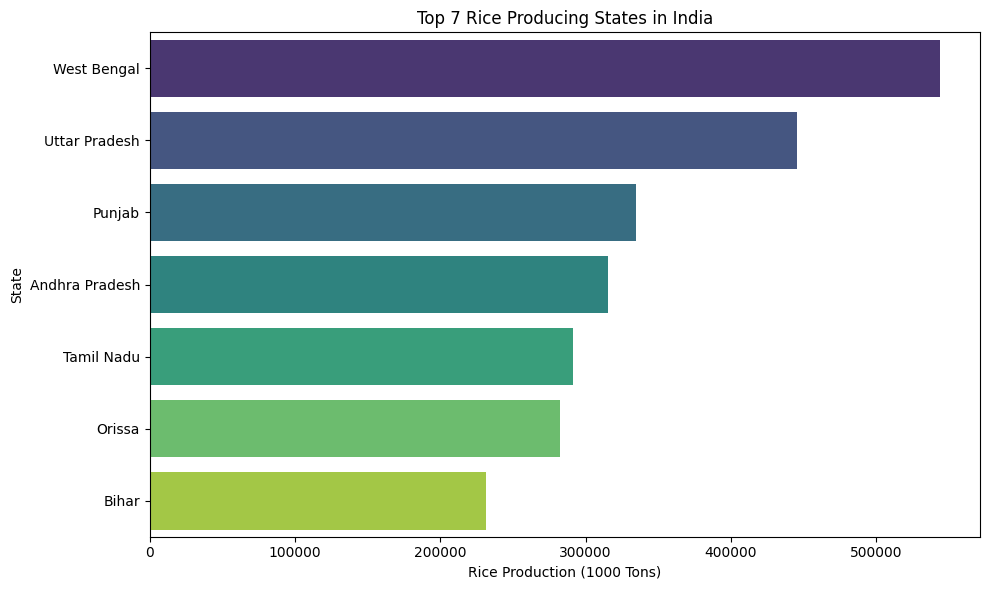

C:\Users\rathi\AppData\Local\Temp\ipykernel_10400\3680677618.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top5_wheat["percentage"] = (


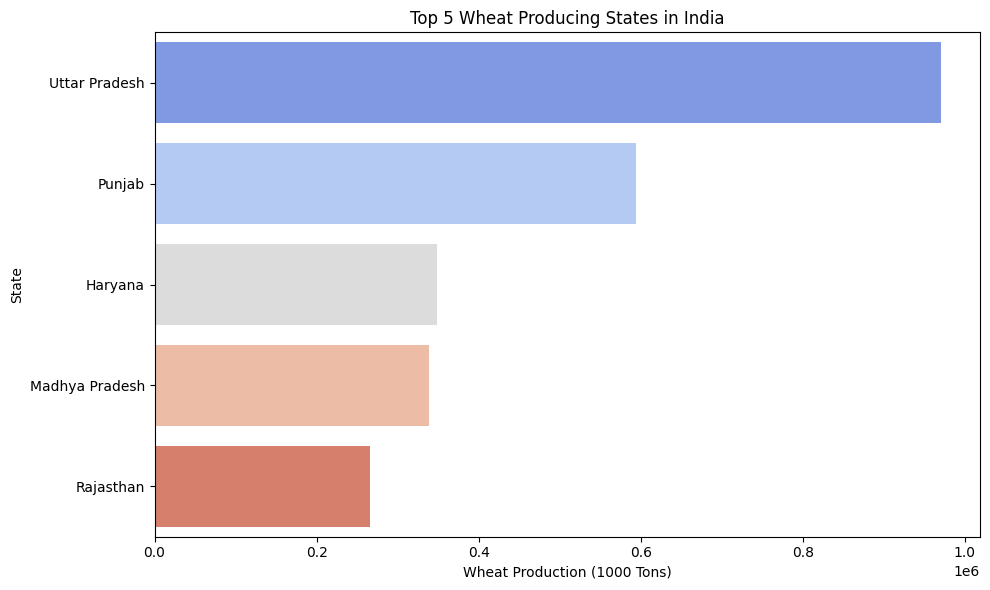

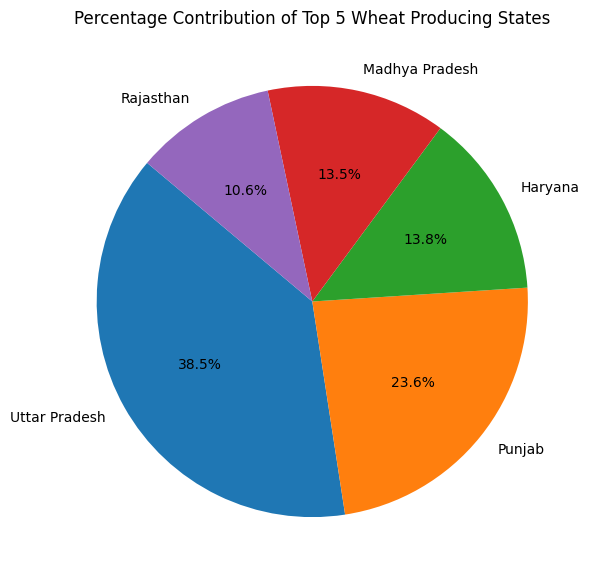

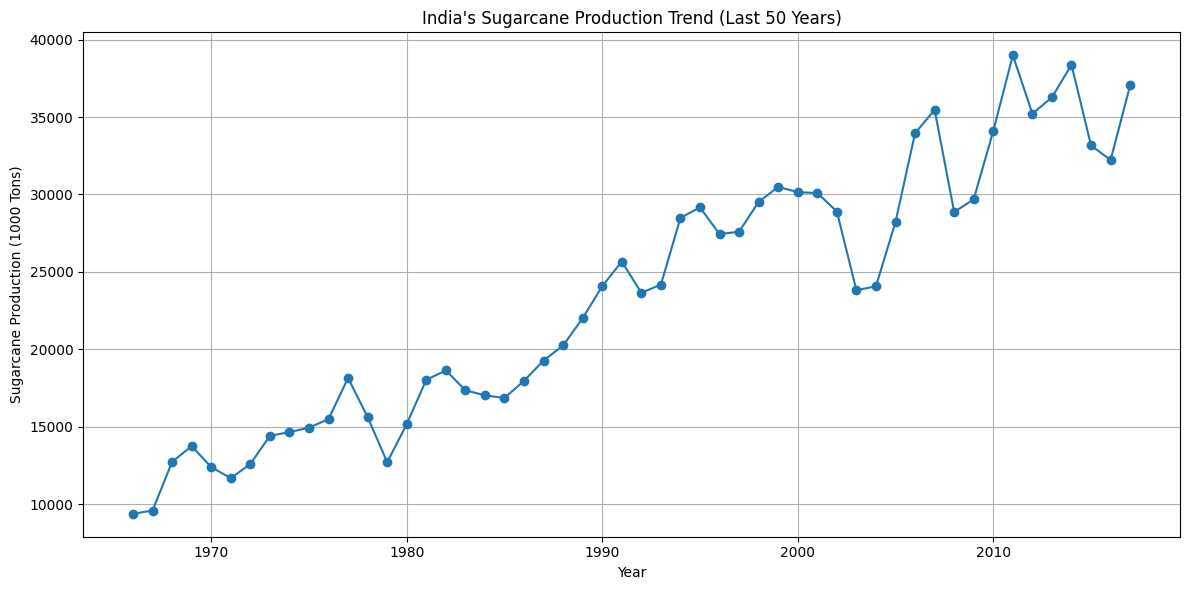

C:\Users\rathi\AppData\Local\Temp\ipykernel_10400\3680677618.py:220: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


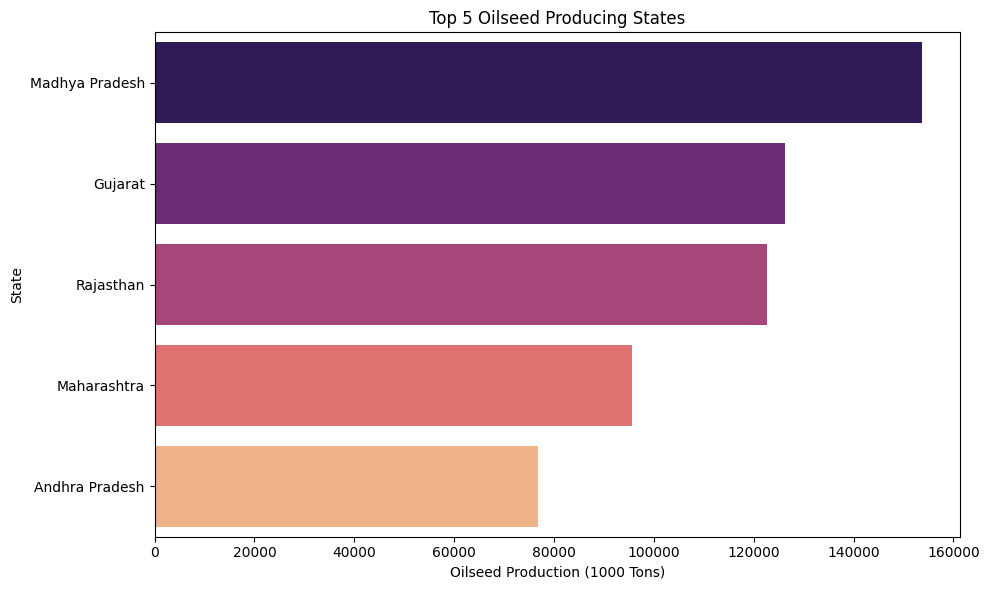

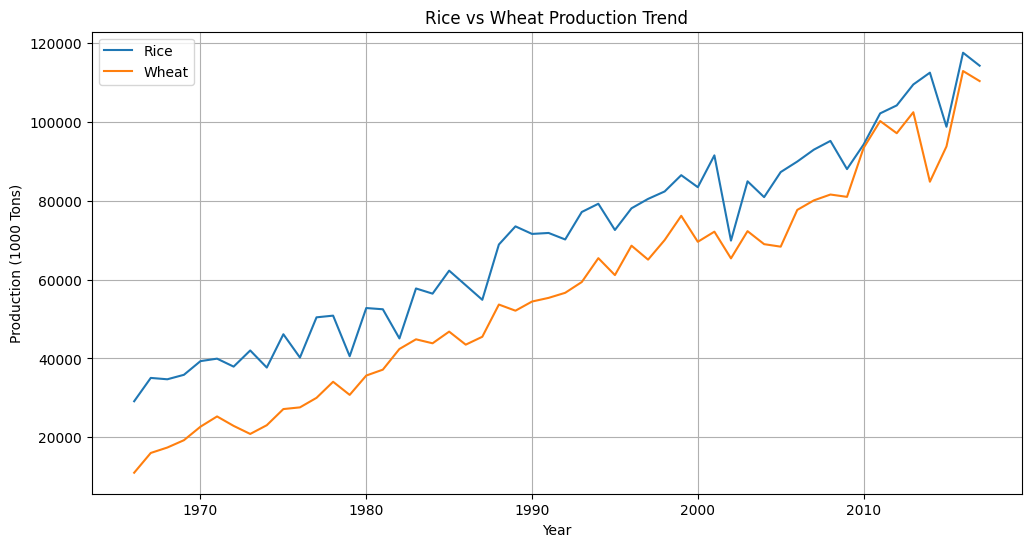

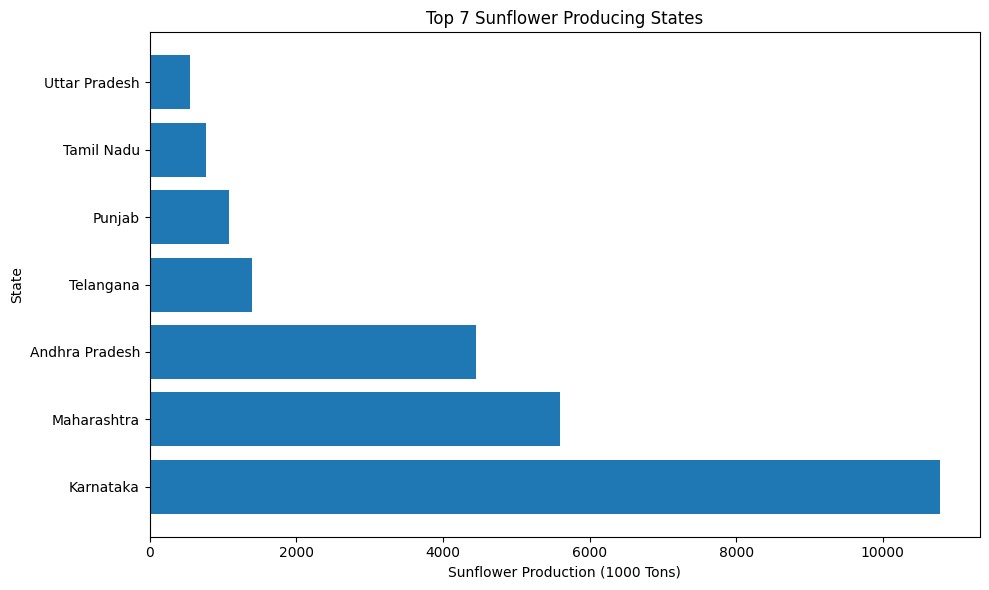

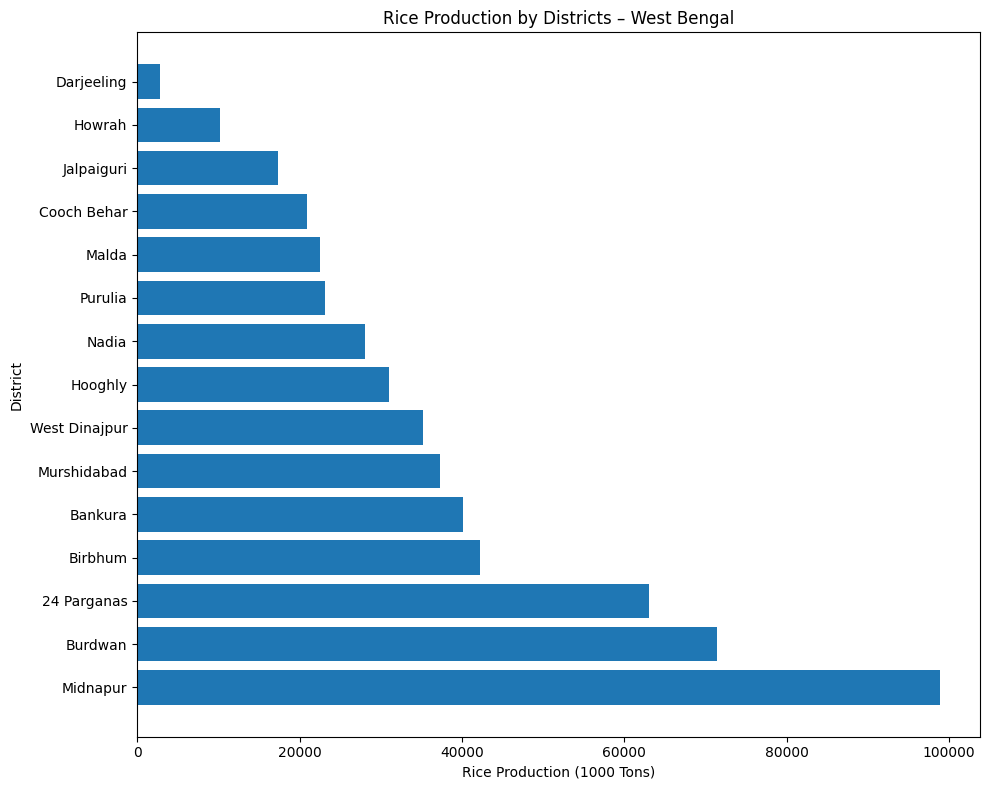

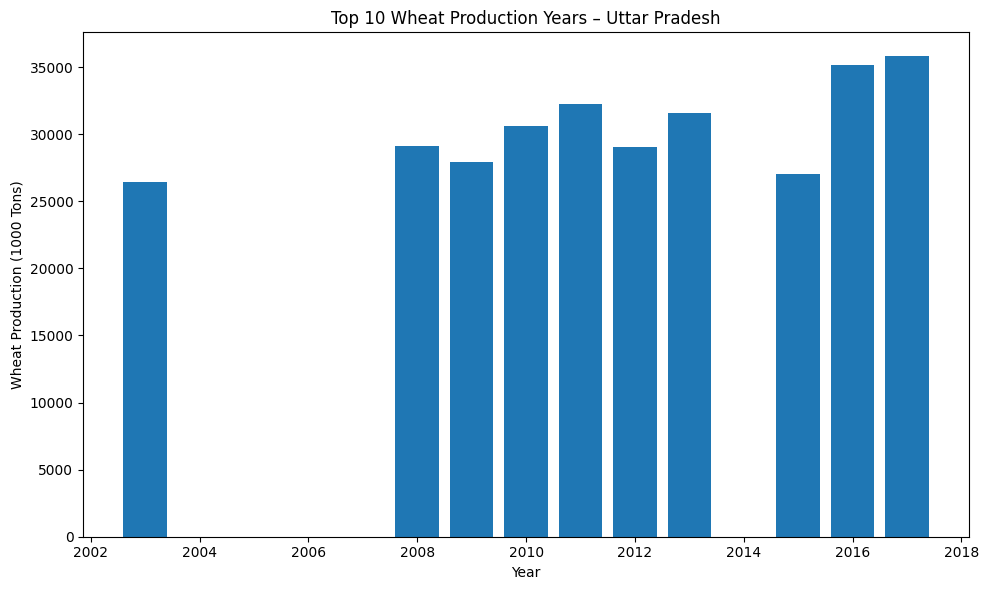

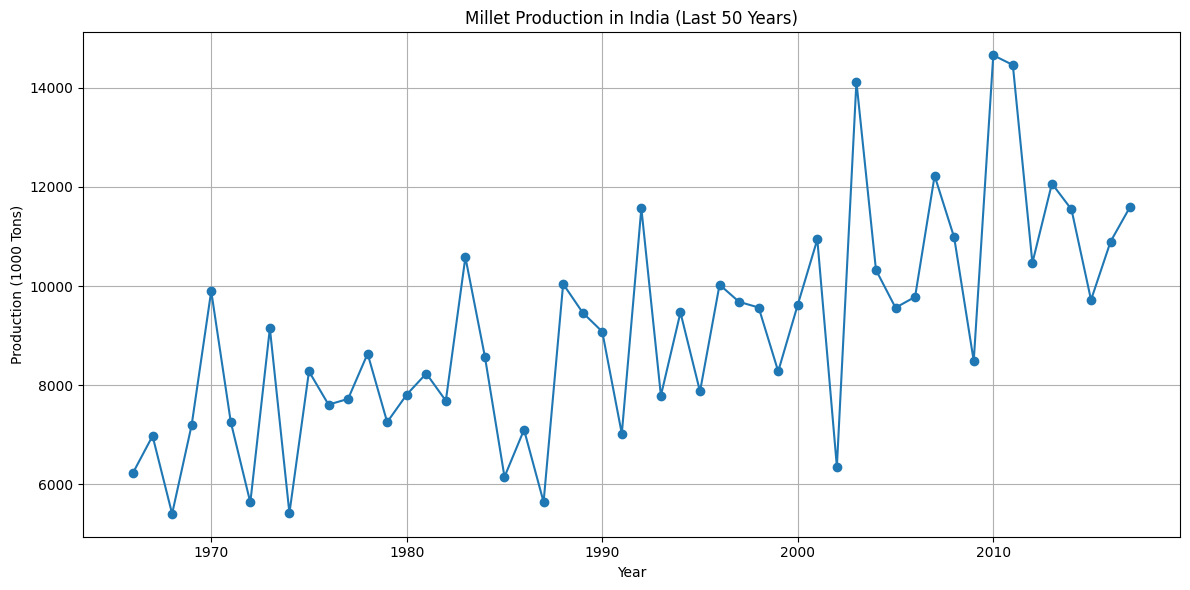

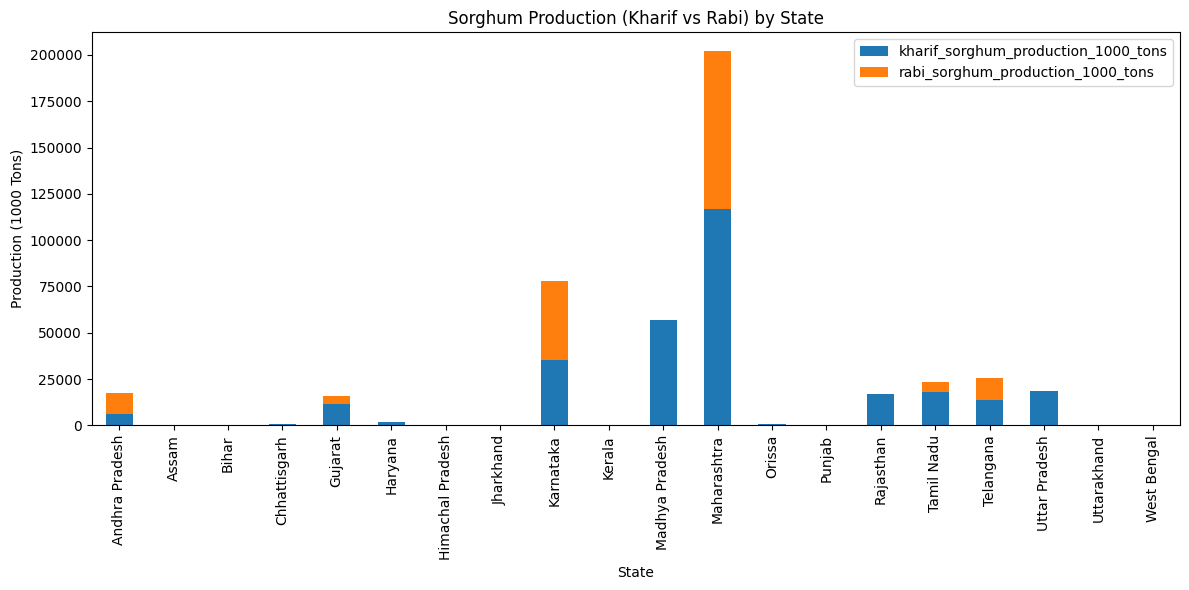

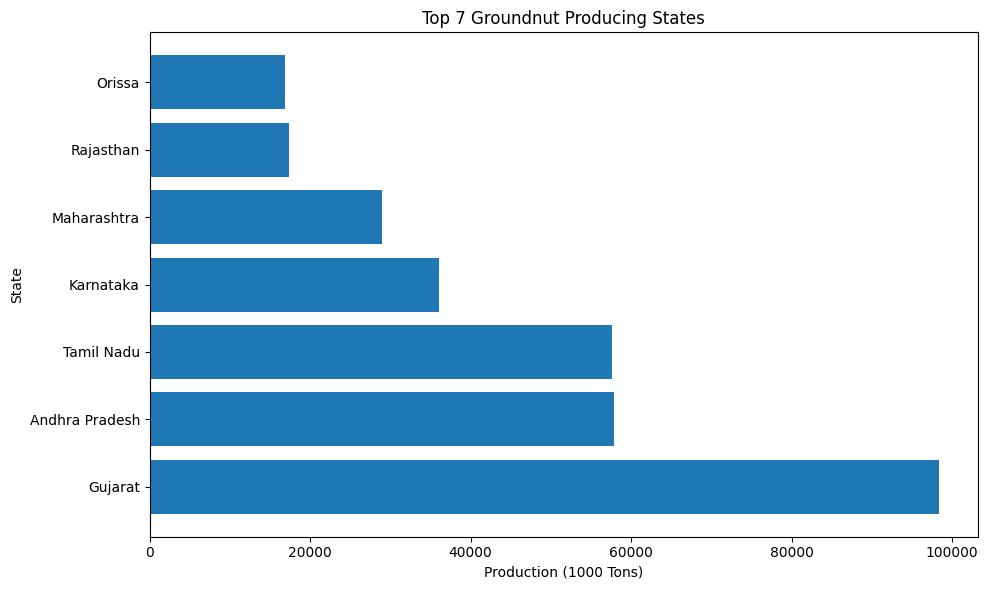

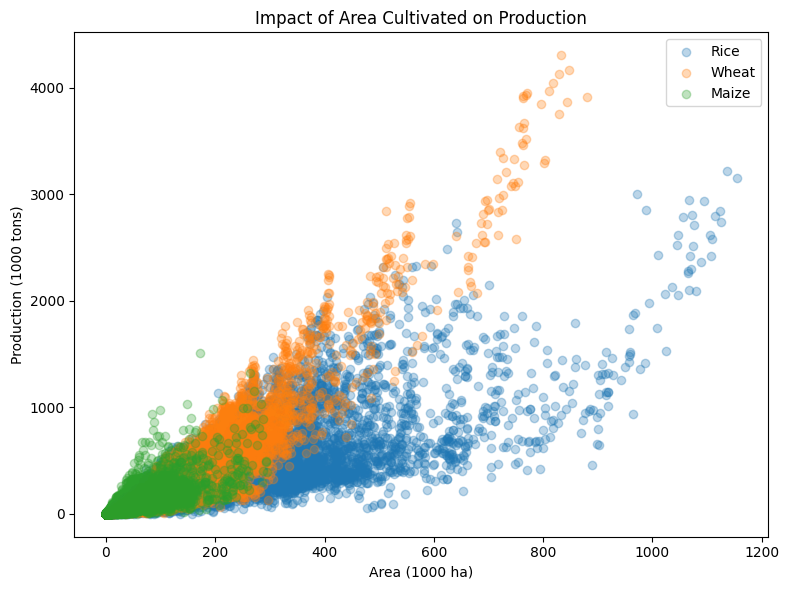

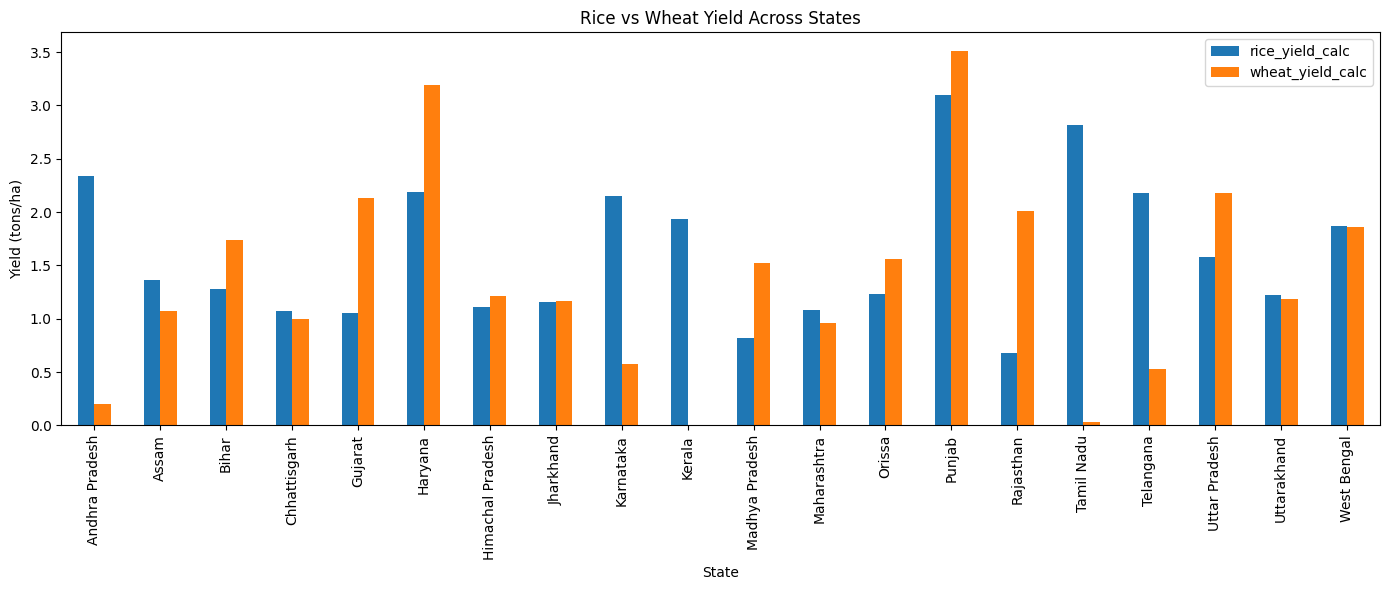

In [2]:
import pandas as pd
import numpy as np

file_path = r"C:\Users\rathi\Documents\PY Project\AgriData Project\Data\ICRISAT-District Level Data.xlsx"

df = pd.read_excel(file_path)

df.shape

df.describe().T

#Starndarzing column names 

df.columns = (
    df.columns
      .str.lower()
      .str.strip()
      .str.replace(" ", "_")
      .str.replace("(", "")
      .str.replace(")", "")
)

df.columns

#Converting Key Identifier Columns

df["year"] = df["year"].astype(int)
df["state_name"] = df["state_name"].astype(str)
df["dist_name"] = df["dist_name"].astype(str)

# Identifying Crop Column Groups

area_cols = [c for c in df.columns if "area_1000_ha" in c]
prod_cols = [c for c in df.columns if "production_1000_tons" in c]
yield_cols = [c for c in df.columns if "yield_kg_per_ha" in c]

len(area_cols), len(prod_cols), len(yield_cols)

# Handling missing Values 

df[area_cols] = df[area_cols].fillna(0)
df[prod_cols] = df[prod_cols].fillna(0)
df[yield_cols] = df[yield_cols].fillna(0)

# Removing Negative Values 

df[area_cols] = df[area_cols].clip(lower=0)
df[prod_cols] = df[prod_cols].clip(lower=0)
df[yield_cols] = df[yield_cols].clip(lower=0)

# Rule Criteria

for area, prod, yld in zip(area_cols, prod_cols, yield_cols):
    mask = df[area] == 0
    df.loc[mask, prod] = 0
    df.loc[mask, yld] = 0

for prod, yld in zip(prod_cols, yield_cols):
    df.loc[df[prod] == 0, yld] = 0


# Recalculating Yield

for area, prod, yld in zip(area_cols, prod_cols, yield_cols):
    calc_col = yld.replace("yield_kg_per_ha", "yield_calc")
    
    df[calc_col] = np.where(
        df[area] > 0,
        (df[prod] * 1000) / (df[area] * 1000),
        0
    )

    df = df.copy() # Rebuilding Dataframe in one memory block



# Removing Infinite Values 

df.replace([np.inf, -np.inf], 0, inplace=True)

# Final Data Quality Check 

df.describe().T

#Saving the Cleaned CSV file 

output_path = r"C:\Users\rathi\Documents\PY Project\AgriData Project\Data\agri_cleaned.csv"
df.to_csv(output_path, index=False)

print("Cleaned file saved as:", output_path)
print("Rows:", df.shape[0], "Columns:", df.shape[1])


# ********** EDA Analysis ************

# 1 Top 7 Rice Producing States

rice_top7 = (
    df.groupby("state_name", as_index=False)
      .agg({"rice_production_1000_tons": "sum"})
      .sort_values("rice_production_1000_tons", ascending=False)
      .head(7)
)

rice_top7

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(
    data=rice_top7,
    x="rice_production_1000_tons",
    y="state_name",
    hue="state_name",
    palette="viridis",
    legend=False
)

plt.title("Top 7 Rice Producing States in India")
plt.xlabel("Rice Production (1000 Tons)")
plt.ylabel("State")
plt.tight_layout()
plt.show()


# 2 Top 5 Wheat Producing States

wheat_state = (
    df.groupby("state_name", as_index=False)
      .agg({"wheat_production_1000_tons": "sum"})
      .sort_values("wheat_production_1000_tons", ascending=False)
)

top5_wheat = wheat_state.head(5)

top5_wheat["percentage"] = (
    top5_wheat["wheat_production_1000_tons"]
    / wheat_state["wheat_production_1000_tons"].sum()
) * 100

top5_wheat

# Bar Chart

plt.figure(figsize=(10,6))
sns.barplot(
    data=top5_wheat,
    x="wheat_production_1000_tons",
    y="state_name",
    hue="state_name",
    palette="coolwarm",
    legend=False
)

plt.title("Top 5 Wheat Producing States in India")
plt.xlabel("Wheat Production (1000 Tons)")
plt.ylabel("State")
plt.tight_layout()
plt.show()

# Pie Chart (% Contribution)


plt.figure(figsize=(7,7))
plt.pie(
    top5_wheat["percentage"],
    labels=top5_wheat["state_name"],
    autopct="%1.1f%%",
    startangle=140
)

plt.title("Percentage Contribution of Top 5 Wheat Producing States")
plt.show()


# 3 India’s Sugarcane Production – Last 50 Years

# Data Preparation

sugarcane_trend = (
    df.groupby("year", as_index=False)
      .agg({"sugarcane_production_1000_tons": "sum"})
)

sugarcane_trend

# Visualization

plt.figure(figsize=(12,6))
plt.plot(
    sugarcane_trend["year"],
    sugarcane_trend["sugarcane_production_1000_tons"],
    marker="o"
)

plt.title("India's Sugarcane Production Trend (Last 50 Years)")
plt.xlabel("Year")
plt.ylabel("Sugarcane Production (1000 Tons)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4 Oilseeds Production – Top 5 States

# Data Prep

oilseed_state = (
    df.groupby("state_name", as_index=False)
      .agg({"oilseeds_production_1000_tons": "sum"})
      .sort_values("oilseeds_production_1000_tons", ascending=False)
      .head(5)
)

oilseed_state

# Plot 

plt.figure(figsize=(10,6))
sns.barplot(
    data=oilseed_state,
    x="oilseeds_production_1000_tons",
    y="state_name",
    palette="magma"
)

plt.title("Top 5 Oilseed Producing States")
plt.xlabel("Oilseed Production (1000 Tons)")
plt.ylabel("State")
plt.tight_layout()
plt.show()

# 6 Rice vs Wheat Production Comparison

# Data Prep

crop_compare = (
    df.groupby("year", as_index=False)
      .agg({
          "rice_production_1000_tons": "sum",
          "wheat_production_1000_tons": "sum"
      })
)

# Plot 

plt.figure(figsize=(12,6))
plt.plot(crop_compare["year"], crop_compare["rice_production_1000_tons"], label="Rice")
plt.plot(crop_compare["year"], crop_compare["wheat_production_1000_tons"], label="Wheat")

plt.title("Rice vs Wheat Production Trend")
plt.xlabel("Year")
plt.ylabel("Production (1000 Tons)")
plt.legend()
plt.grid(True)
plt.show()

# 7 Top 7 Sunflower Producing States

sunflower_top7 = (
    df.groupby("state_name", as_index=False)
      .agg({"sunflower_production_1000_tons": "sum"})
      .sort_values("sunflower_production_1000_tons", ascending=False)
      .head(7)
)

plt.figure(figsize=(10,6))
plt.barh(sunflower_top7["state_name"], sunflower_top7["sunflower_production_1000_tons"])
plt.title("Top 7 Sunflower Producing States")
plt.xlabel("Sunflower Production (1000 Tons)")
plt.ylabel("State")
plt.tight_layout()
plt.show()

# 8 Rice Production by West Bengal Districts

wb_rice = (
    df[df["state_name"] == "West Bengal"]
    .groupby("dist_name", as_index=False)
    .agg({"rice_production_1000_tons": "sum"})
    .sort_values("rice_production_1000_tons", ascending=False)
)

plt.figure(figsize=(10,8))
plt.barh(wb_rice["dist_name"], wb_rice["rice_production_1000_tons"])
plt.title("Rice Production by Districts – West Bengal")
plt.xlabel("Rice Production (1000 Tons)")
plt.ylabel("District")
plt.tight_layout()
plt.show()

# 9 Top 10 Wheat Production Years from Uttar Pradesh

up_wheat_years = (
    df[df["state_name"] == "Uttar Pradesh"]
    .groupby("year", as_index=False)
    .agg({"wheat_production_1000_tons": "sum"})
    .sort_values("wheat_production_1000_tons", ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
plt.bar(up_wheat_years["year"], up_wheat_years["wheat_production_1000_tons"])
plt.title("Top 10 Wheat Production Years – Uttar Pradesh")
plt.xlabel("Year")
plt.ylabel("Wheat Production (1000 Tons)")
plt.tight_layout()
plt.show()


millet_prod_cols = [
    "pearl_millet_production_1000_tons",
    "finger_millet_production_1000_tons"
]

df["millet_total_production_1000_tons"] = df[millet_prod_cols].sum(axis=1)

# 10 Millet Production (Last 50 Years)

millet_trend = (
    df.groupby("year", as_index=False)
      .agg({"millet_total_production_1000_tons": "sum"})
)


plt.figure(figsize=(12,6))
plt.plot(
    millet_trend["year"],
    millet_trend["millet_total_production_1000_tons"],
    marker="o"
)

plt.title("Millet Production in India (Last 50 Years)")
plt.xlabel("Year")
plt.ylabel("Production (1000 Tons)")
plt.grid(True)
plt.tight_layout()
plt.show()


# 11 Sorghum Production (Kharif & Rabi) by Region

sorghum_region = (
    df.groupby("state_name", as_index=False)
      .agg({
          "kharif_sorghum_production_1000_tons": "sum",
          "rabi_sorghum_production_1000_tons": "sum"
      })
)

sorghum_region.plot(
    x="state_name",
    kind="bar",
    stacked=True,
    figsize=(12,6)
)

plt.title("Sorghum Production (Kharif vs Rabi) by State")
plt.xlabel("State")
plt.ylabel("Production (1000 Tons)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 12 Top 7 States for Groundnut Production

groundnut_top7 = (
    df.groupby("state_name", as_index=False)
      .agg({"groundnut_production_1000_tons": "sum"})
      .sort_values("groundnut_production_1000_tons", ascending=False)
      .head(7)
)

plt.figure(figsize=(10,6))
plt.barh(groundnut_top7["state_name"], groundnut_top7["groundnut_production_1000_tons"])
plt.title("Top 7 Groundnut Producing States")
plt.xlabel("Production (1000 Tons)")
plt.ylabel("State")
plt.tight_layout()
plt.show()


# 13 Soybean Production (Top 5 States) & Yield Efficiency

soybean_top5 = (
    df.groupby("state_name", as_index=False)
      .agg({
          "soyabean_production_1000_tons": "sum",
          "soyabean_yield_calc": "mean"
      })
      .sort_values("soyabean_production_1000_tons", ascending=False)
      .head(5)
)

soybean_top5

# 14 Oilseed Production in Major States

oilseed_major = (
    df.groupby("state_name", as_index=False)
      .agg({"oilseeds_production_1000_tons": "sum"})
      .sort_values("oilseeds_production_1000_tons", ascending=False)
)

oilseed_major.head(10)


# 15 Impact of Area Cultivated on Production

plt.figure(figsize=(8,6))
plt.scatter(df["rice_area_1000_ha"], df["rice_production_1000_tons"], alpha=0.3, label="Rice")
plt.scatter(df["wheat_area_1000_ha"], df["wheat_production_1000_tons"], alpha=0.3, label="Wheat")
plt.scatter(df["maize_area_1000_ha"], df["maize_production_1000_tons"], alpha=0.3, label="Maize")

plt.title("Impact of Area Cultivated on Production")
plt.xlabel("Area (1000 ha)")
plt.ylabel("Production (1000 tons)")
plt.legend()
plt.tight_layout()
plt.show()


# 16 Rice vs Wheat Yield Across States

yield_state = (
    df.groupby("state_name", as_index=False)
      .agg({
          "rice_yield_calc": "mean",
          "wheat_yield_calc": "mean"
      })
)

yield_state.plot(
    x="state_name",
    kind="bar",
    figsize=(14,6)
)

plt.title("Rice vs Wheat Yield Across States")
plt.xlabel("State")
plt.ylabel("Yield (tons/ha)")
plt.tight_layout()
plt.show()










